In [0]:
import matplotlib.pyplot as plt
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, StringType
from pyspark.sql.functions import monotonically_increasing_id, col, substring, mean, lit, count
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from functools import reduce

In [0]:
spark = SparkSession.builder.appName("model") \
    .config("spark.executor.memory", "100g") \
    .config("spark.driver.memory", "10g") \
    .config("spark.executor.cores", 16) \
    .config("spark.executor.instances", 16) \
    .config("spark.dynamicAllocation.enabled", "true") \
    .getOrCreate()
spark

In [0]:
path = r"/FileStore/tables/house_price_1995.csv"
column_name = ['transactionID','price','date','postcode','propertyType','old/new','duration','PAON','SAON','street','locality','town/city','district','country','categoryType','recordStatus']
schema = StructType([StructField(name, StringType(), True) for name in column_name])
df = spark.read.csv(path,header=True)
for i in range(1996,2024):
    path = '/FileStore/tables/house_price_'+str(i)+'.csv'
    df = df.unionAll(spark.read.csv(path,header=True))

oldColumns = df.schema.names
df = reduce(lambda df, idx: df.withColumnRenamed(oldColumns[idx], column_name[idx]), range(len(oldColumns)), df)
#df.show()

In [0]:
df.printSchema(),df.describe().toPandas().iloc[0],df.count()

root
 |-- transactionID: string (nullable = true)
 |-- price: string (nullable = true)
 |-- date: string (nullable = true)
 |-- postcode: string (nullable = true)
 |-- propertyType: string (nullable = true)
 |-- old/new: string (nullable = true)
 |-- duration: string (nullable = true)
 |-- PAON: string (nullable = true)
 |-- SAON: string (nullable = true)
 |-- street: string (nullable = true)
 |-- locality: string (nullable = true)
 |-- town/city: string (nullable = true)
 |-- district: string (nullable = true)
 |-- country: string (nullable = true)
 |-- categoryType: string (nullable = true)
 |-- recordStatus: string (nullable = true)



(None,
 summary            count
 transactionID    1528903
 price            1528903
 date             1528903
 postcode         1526680
 propertyType     1528903
 old/new          1528903
 duration         1528903
 PAON             1528619
 SAON              180715
 street           1504323
 locality          913570
 town/city        1528903
 district         1528903
 country          1528903
 categoryType     1528903
 recordStatus     1528903
 Name: 0, dtype: object,
 1528903)

# Data Preprocessing

1. Transaction ID

Each house has a unique transaction ID, according to common sense, this ID should not effect house price, so it can be dropped.

In [0]:
df.select('transactionID').distinct().count()

1528903

In [0]:
df = df.drop('transactionID')
#df.show()

2. Price

It's the label, and there's no missing value, so leave it be.

In [0]:
df = df.withColumn('price', col('price').cast('float'))

3. Date

Convert this into three new integer columns: year, month, day

In [0]:
df.select('date').distinct().count()

9372

In [0]:
df = df.withColumn('year',substring(col('date'), 1, 4))
df = df.withColumn('year', col('year').cast('int'))
df = df.withColumn('month',substring(col('date'), 6, 2))
df = df.withColumn('month', col('month').cast('int'))
df = df.withColumn('day',substring(col('date'), 9, 2))
df = df.withColumn('day', col('day').cast('int'))
df = df.drop('date')
#df.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Trend of Average Housing Prices Changes from 1995 to 2023')

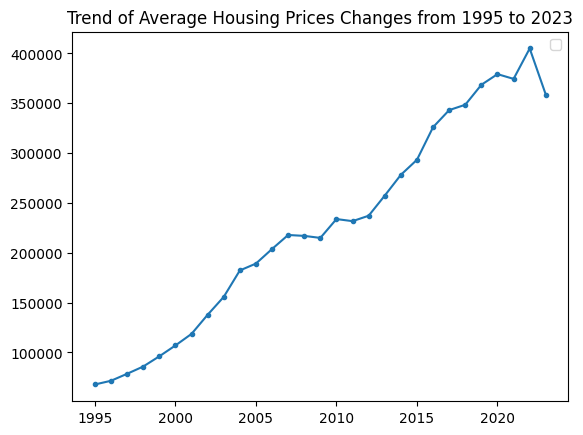

In [0]:
df_year = df.groupBy('year').mean('price')
df_year = df_year.toPandas()
plt.figure()
plt.plot(df_year['year'],df_year['avg(price)'],marker='.')
plt.legend()
plt.title('Trend of Average Housing Prices Changes from 1995 to 2023')

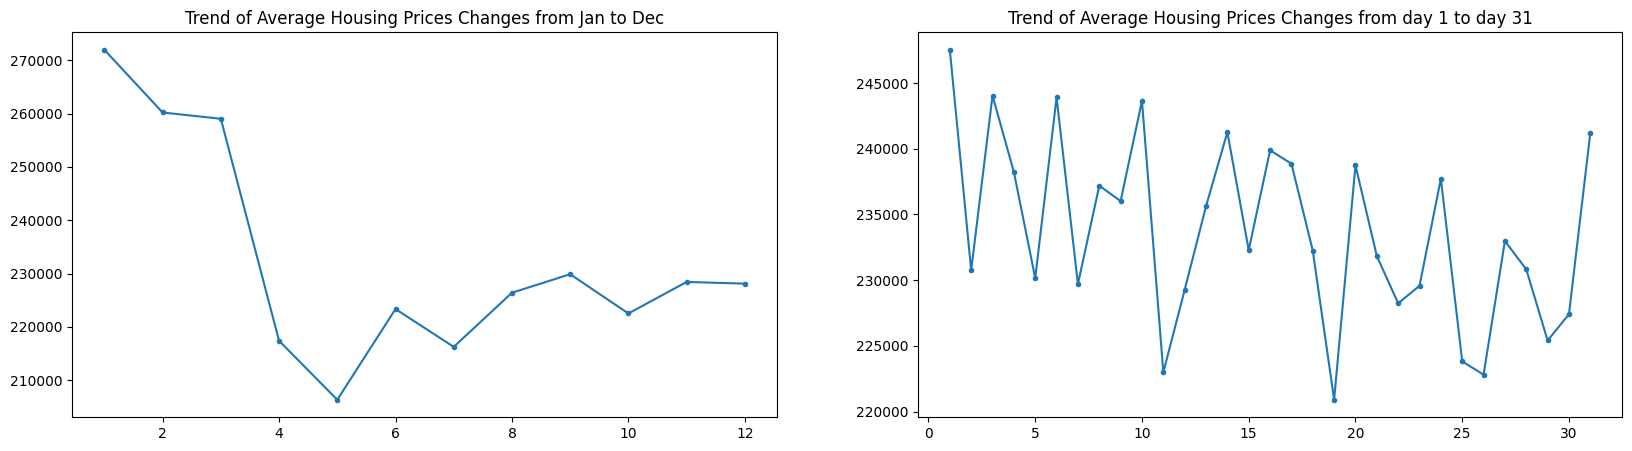

In [0]:
# the price distribution over different months and days
df_month = df.groupBy('month').mean('price').toPandas().sort_values(by='month',ascending=True)
df_day = df.groupBy('day').mean('price').toPandas().sort_values(by='day',ascending=True)
fig,axes = plt.subplots(1,2,figsize=(20,5))
axes[0].plot(df_month['month'],df_month['avg(price)'],marker='.')
axes[0].set_title('Trend of Average Housing Prices Changes from Jan to Dec')
axes[1].plot(df_day['day'],df_day['avg(price)'],marker='.')
axes[1].set_title('Trend of Average Housing Prices Changes from day 1 to day 31')
plt.show()

4. postcode

Every house has its own unique postcode, and its geographical location can be represented by other features, e.g. locality, country, etc. So drop this column.

In [0]:
df.select('postcode').distinct().count()

704312

In [0]:
df = df.drop('postcode')

5. Property Type

There are only 5 different values, use one-hot to encode this feature

In [0]:
df.select('propertyType').distinct().count()

5

Text(0.5, 1.0, 'Distribution of Property Type')

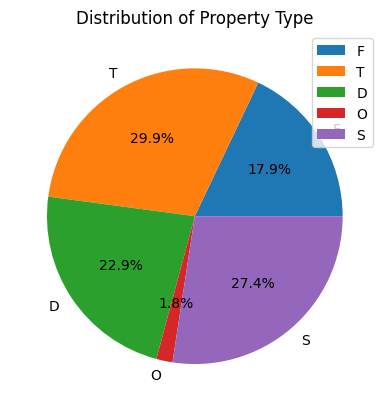

In [0]:
df_propertyType = df.groupBy('propertyType').count()
df_propertyType = df_propertyType.toPandas()
plt.figure()
plt.pie(df_propertyType['count'],labels=df_propertyType['propertyType'].unique(),autopct='%1.1f%%')
plt.legend()
plt.title('Distribution of Property Type')

Text(0.5, 1.0, 'Average price of each Property Type')

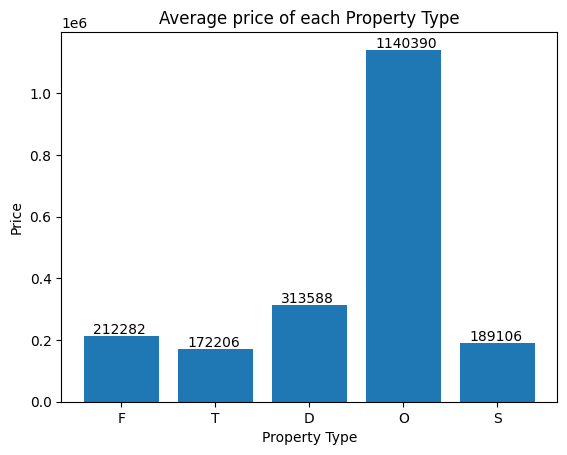

In [0]:
df_price_mean = df.groupBy('propertyType').mean('price').toPandas()
plt.figure()
plt.bar(df_price_mean['propertyType'].unique(),df_price_mean['avg(price)'])
plt.text(-0.3,df_price_mean['avg(price)'][0]+7000,int(df_price_mean['avg(price)'][0]))
plt.text(0.7,df_price_mean['avg(price)'][1]+7000,int(df_price_mean['avg(price)'][1]))
plt.text(1.7,df_price_mean['avg(price)'][2]+7000,int(df_price_mean['avg(price)'][2]))
plt.text(2.7,df_price_mean['avg(price)'][3]+7000,int(df_price_mean['avg(price)'][3]))
plt.text(3.7,df_price_mean['avg(price)'][4]+7000,int(df_price_mean['avg(price)'][4]))
plt.xlabel('Property Type')
plt.ylabel('Price')
plt.title('Average price of each Property Type')

In [0]:
indexer = StringIndexer(inputCol='propertyType', outputCol='propertyType_index')
df = indexer.fit(df).transform(df)
encoder = OneHotEncoder(inputCol='propertyType_index', outputCol='propertyType_onehot')
df = encoder.fit(df).transform(df)
df = df.drop('propertyType','propertyType_index')
#df.show()

6. Old/new

There are only 2 different values, let old=1, new=0

In [0]:
df.select('old/new').distinct().count()

2

Text(0.5, 1.0, 'Distribution of Old/New')

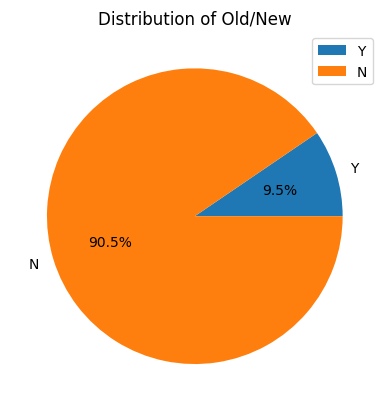

In [0]:
df_oldnew = df.groupBy('old/new').count()
df_oldnew = df_oldnew.toPandas()
plt.figure()
plt.pie(df_oldnew['count'],labels=df_oldnew['old/new'].unique(),autopct='%1.1f%%')
plt.legend()
plt.title('Distribution of Old/New')

Text(0.5, 1.0, 'Average price of old or new house')

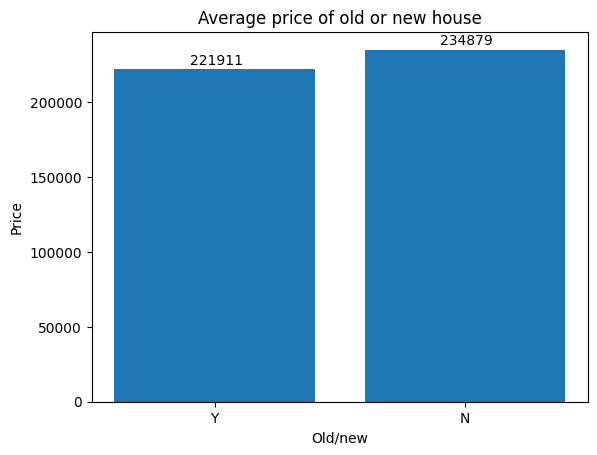

In [0]:
df_price_mean = df.groupBy('old/new').mean('price').toPandas()
plt.figure()
plt.bar(df_price_mean['old/new'].unique(),df_price_mean['avg(price)'])
plt.text(-0.1,df_price_mean['avg(price)'][0]+3000,int(df_price_mean['avg(price)'][0]))
plt.text(0.9,df_price_mean['avg(price)'][1]+3000,int(df_price_mean['avg(price)'][1]))
plt.xlabel('Old/new')
plt.ylabel('Price')
plt.title('Average price of old or new house')

In [0]:
indexer = StringIndexer(inputCol='old/new', outputCol='old/new_index')
df = indexer.fit(df).transform(df)
df = df.drop('old/new')
#df.show()

7. Duration

There are 3 different values, use one-hot to encode this feature

In [0]:
df.select('duration').distinct().count()

3

Text(0.5, 1.0, 'Distribution of Duration')

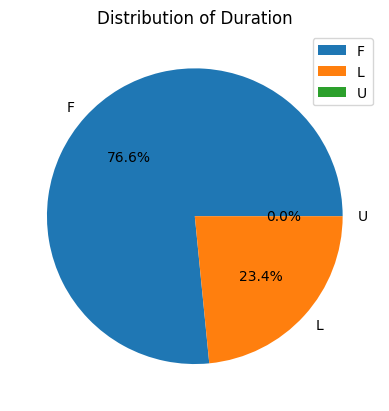

In [0]:
df_duration = df.groupBy('duration').count()
df_duration = df_duration.toPandas()
plt.figure()
plt.pie(df_duration['count'],labels=df_duration['duration'].unique(),autopct='%1.1f%%')
plt.legend()
plt.title('Distribution of Duration')

Text(0.5, 1.0, 'Average price of each duration')

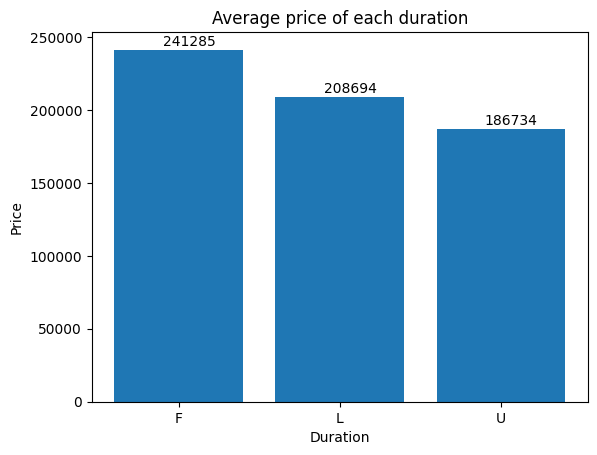

In [0]:
df_price_mean = df.groupBy('duration').mean('price').toPandas()
plt.figure()
plt.bar(df_price_mean['duration'].unique(),df_price_mean['avg(price)'])
plt.text(-0.1,df_price_mean['avg(price)'][0]+3000,int(df_price_mean['avg(price)'][0]))
plt.text(0.9,df_price_mean['avg(price)'][1]+3000,int(df_price_mean['avg(price)'][1]))
plt.text(1.9,df_price_mean['avg(price)'][2]+3000,int(df_price_mean['avg(price)'][2]))
plt.xlabel('Duration')
plt.ylabel('Price')
plt.title('Average price of each duration')

In [0]:
indexer = StringIndexer(inputCol='duration', outputCol='duration_index')
df = indexer.fit(df).transform(df)
encoder = OneHotEncoder(inputCol='duration_index', outputCol='duration_onehot')
df = encoder.fit(df).transform(df)
df = df.drop('duration','duration_index')
#df.show()

8.PAON

First, fill in missing value with mode, then use label encoding, target encoding, frequency encoding to create 3 new numerical features.

In [0]:
df.select('PAON').distinct().count()

102298

In [0]:
mode_PAON = df.groupBy('PAON').count().orderBy(col('count').desc()).limit(1).select('PAON').collect()[0][0]
df = df.na.fill(mode_PAON, ['PAON'])

In [0]:
# label encoding
indexer = StringIndexer(inputCol='PAON', outputCol='PAON_index')
df = indexer.fit(df).transform(df)

In [0]:
# target encoding
mean_target = df.groupBy('PAON').agg(mean('price').alias("PAON_target"))
df = df.join(mean_target, on='PAON', how='left_outer')

In [0]:
# frequency encoding
category_counts = df.groupBy('PAON').agg(count(lit(1)).alias('PAON_frequency'))
df = df.join(category_counts, on='PAON', how='left_outer')

In [0]:
df = df.drop('PAON')
#df.show()

9.SAON

Too many missing values (only 184661 non-null out of 1578903), drop this column.

In [0]:
df.select('SAON').distinct().count()

9061

In [0]:
df = df.drop('SAON')

10. Street

First, fill in missing value with mode, then use label encoding, target encoding, frequency encoding to create 3 new numerical features.

In [0]:
df.select('street').distinct().count()

214214

In [0]:
# the most frequent element is null, so fill in missing values with the second frequent value
category_counts = df.filter(col('street').isNotNull()).groupBy('street').agg(count(lit(1)).alias('frequency'))
second_most_frequent_category = (category_counts.orderBy(col("frequency").desc()).select('street').limit(1).collect()[0]['street'])
df = df.na.fill({'street': second_most_frequent_category})

# label encoding
indexer = StringIndexer(inputCol='street', outputCol='street_index')
df = indexer.fit(df).transform(df)
# target encoding
mean_target = df.groupBy('street').agg(mean('price').alias("street_target"))
df = df.join(mean_target, on='street', how='left_outer')
# frequency encoding
category_counts = df.groupBy('street').agg(count(lit(1)).alias('street_frequency'))
df = df.join(category_counts, on='street', how='left_outer')

In [0]:
df = df.drop('street')
#df.show()

11.  Locality

Too many missing values (only 1780834 non-null out of 2928931), and features like street, town/city, district, country carry enough information, so drop this feature.

In [0]:
df.select('locality').distinct().count()

18701

In [0]:
df = df.drop('locality')

12. Town/City

Use label encoding, target encoding, frequency encoding to create 3 new numerical features.

In [0]:
df.select('town/city').distinct().count()

1167

In [0]:
# label encoding
indexer = StringIndexer(inputCol='town/city', outputCol='town/city_index')
df = indexer.fit(df).transform(df)
# target encoding
mean_target = df.groupBy('town/city').agg(mean('price').alias("town/city_target"))
df = df.join(mean_target, on='town/city', how='left_outer')
# frequency encoding
category_counts = df.groupBy('town/city').agg(count(lit(1)).alias('town/city_frequency'))
df = df.join(category_counts, on='town/city', how='left_outer')
df = df.drop('town/city')

13. District

Use label encoding, target encoding, frequency encoding to create 3 new numerical features.

In [0]:
df.select('district').distinct().count()

464

In [0]:
# label encoding
indexer = StringIndexer(inputCol='district', outputCol='district_index')
df = indexer.fit(df).transform(df)
# target encoding
mean_target = df.groupBy('district').agg(mean('price').alias("district_target"))
df = df.join(mean_target, on='district', how='left_outer')
# frequency encoding
category_counts = df.groupBy('district').agg(count(lit(1)).alias('district_frequency'))
df = df.join(category_counts, on='district', how='left_outer')
df = df.drop('district')

14. Country

Use label encoding, target encoding, frequency encoding to create 3 new numerical features.

In [0]:
df.select('country').distinct().count()

132

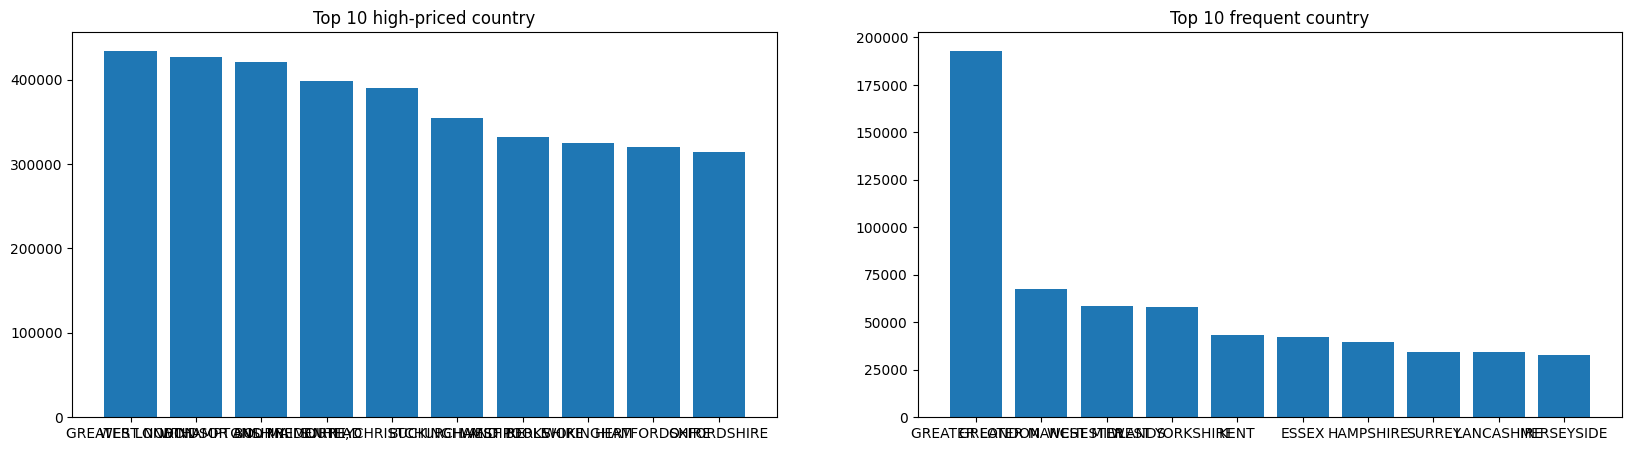

Top 10 high-priced country:  ['GREATER LONDON' 'WEST NORTHAMPTONSHIRE' 'WINDSOR AND MAIDENHEAD'
 'SURREY' 'BOURNEMOUTH, CHRISTCHURCH AND POOLE' 'BUCKINGHAMSHIRE'
 'WEST BERKSHIRE' 'WOKINGHAM' 'HERTFORDSHIRE' 'OXFORDSHIRE']
Top 10 frequent country:  ['GREATER LONDON' 'GREATER MANCHESTER' 'WEST MIDLANDS' 'WEST YORKSHIRE'
 'KENT' 'ESSEX' 'HAMPSHIRE' 'SURREY' 'LANCASHIRE' 'MERSEYSIDE']


In [0]:
# Top 10 frequent country and top 10 high-priced country
df_country_price = df.groupBy('country').mean('price').toPandas().sort_values(by='avg(price)',ascending=False)[:10]
df_country_count = df.groupBy('country').count().toPandas().sort_values(by='count',ascending=False)[:10]
fig,axes = plt.subplots(1,2,figsize=(20,5))
axes[0].bar(df_country_price['country'].values,df_country_price['avg(price)'].values)
axes[0].set_title('Top 10 high-priced country')
axes[1].bar(df_country_count['country'].values,df_country_count['count'].values)
axes[1].set_title('Top 10 frequent country')
plt.show()
print('Top 10 high-priced country: ',df_country_price['country'].values)
print('Top 10 frequent country: ',df_country_count['country'].values)

In [0]:
# label encoding
indexer = StringIndexer(inputCol='country', outputCol='country_index')
df = indexer.fit(df).transform(df)
# target encoding
mean_target = df.groupBy('country').agg(mean('price').alias("country_target"))
df = df.join(mean_target, on='country', how='left_outer')
# frequency encoding
category_counts = df.groupBy('country').agg(count(lit(1)).alias('country_frequency'))
df = df.join(category_counts, on='country', how='left_outer')
df = df.drop('country')

15. Category Type

There are only 2 different values, Let A=0, B=1

In [0]:
df.select('categoryType').distinct().count()

2

Text(0.5, 1.0, 'Distribution of categoryType')

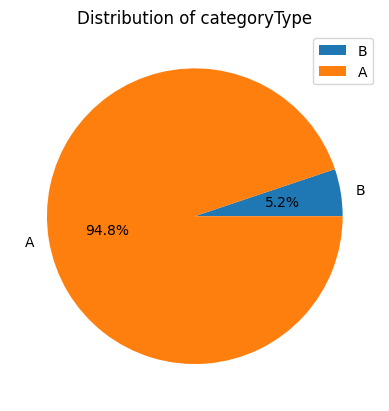

In [0]:
df_categoryType = df.groupBy('categoryType').count().toPandas()
plt.figure()
plt.pie(df_categoryType['count'],labels=df_categoryType['categoryType'].unique(),autopct='%1.1f%%')
plt.legend()
plt.title('Distribution of categoryType')

Text(0.5, 1.0, 'Average price of each category type')

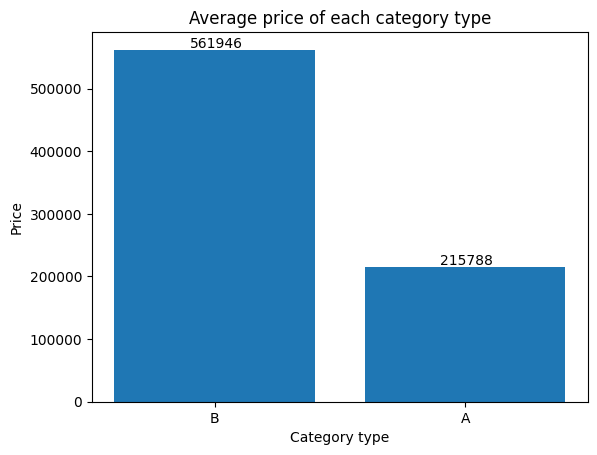

In [0]:
df_price_mean = df.groupBy('categoryType').mean('price').toPandas()
plt.figure()
plt.bar(df_price_mean['categoryType'].unique(),df_price_mean['avg(price)'])
plt.text(-0.1,df_price_mean['avg(price)'][0]+3000,int(df_price_mean['avg(price)'][0]))
plt.text(0.9,df_price_mean['avg(price)'][1]+3000,int(df_price_mean['avg(price)'][1]))
plt.xlabel('Category type')
plt.ylabel('Price')
plt.title('Average price of each category type')

In [0]:
indexer = StringIndexer(inputCol='categoryType', outputCol='categoryType_index')
df = indexer.fit(df).transform(df)
df = df.drop('categoryType')
#df.show()

16. Record Status

There is only 1 unique values in this column, so drop this feature.

In [0]:
df.select('recordStatus').distinct().count()

1

In [0]:
df = df.drop('recordStatus')

In [0]:
df.show()

+---------+----+-----+---+-------------------+-------------+---------------+----------+------------------+--------------+------------+-------------+----------------+---------------+------------------+-------------------+--------------+------------------+------------------+-------------+------------------+-----------------+------------------+
|    price|year|month|day|propertyType_onehot|old/new_index|duration_onehot|PAON_index|       PAON_target|PAON_frequency|street_index|street_target|street_frequency|town/city_index|  town/city_target|town/city_frequency|district_index|   district_target|district_frequency|country_index|    country_target|country_frequency|categoryType_index|
+---------+----+-----+---+-------------------+-------------+---------------+----------+------------------+--------------+------------+-------------+----------------+---------------+------------------+-------------------+--------------+------------------+------------------+-------------+------------------+------

In [0]:
num_rows = df.count()
num_columns = len(df.columns)
num_rows,num_columns

(1528903, 23)

In [0]:
df.write.parquet(r'/FileStore/tables/data_preprocessed.parquet',mode="overwrite")